# Jones Matrices

The electric field is a two component vector: 

\begin{equation}
\vec{E} = \begin{pmatrix}
    E_x \\
    E_y
\end{pmatrix}
\end{equation}

upon which operations are made using Jones matrices. Jones matrices for waveplates can be derived generally from the Jones matrix of a phase retarder:

\begin{equation}
J_R(\phi) = \begin{pmatrix}
    e^{i\phi/2} & 0 \\
    0 & e^{-i\phi/2}
\end{pmatrix}
\end{equation}

A few well known Jones matrices are those for a quarter wave plate where $\phi = \pi / 2$ and a half wave plate where $\phi=\pi$:

\begin{equation}
J_R(\pi/2) = \begin{pmatrix}
    e^{i\pi/4} & 0 \\
    0 & e^{-i\pi/4}
\end{pmatrix}
\end{equation}

\begin{equation}
J_R(\pi) = \begin{pmatrix}
    e^{i\pi/2} & 0 \\
    0 & e^{-i\pi/2}
\end{pmatrix}
\end{equation}

The last element that is needed is how to write down the Jones matrix for a rotated wave plate. This can be derived from linear algebra for a rotated operator: 

\begin{equation}
J_R(\phi,\theta)=R(-\theta)J_R(\phi)R(\theta)
\end{equation}

Where $R(\theta)$ is the rotation operator:

\begin{equation}
R(\theta)=\begin{pmatrix}
    \cos(\theta) & \sin(\theta) \\
    -\sin(\theta) & \cos(\theta)
\end{pmatrix}
\end{equation}

# Cavity transmission

Here we aim to calculate the transmission function for the following cavity:

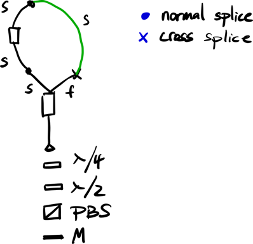

In particular, the laser is composed of:

1. A nonlinear fiber loop cross-spliced to a polarization beam combiner
2. A free space package containing a quarter and a half wave plate, a polarizing beam splitter and a mirror

The point here is that the cavity transmission will depend on the orientation of the wave plates. The goal is to make it unfavorable for CW where the nonlinear phase shift $\phi_{nl}=0$, and favorable for mode-locked operation where $\phi_{nl}>0$

# Python

We will generate an interactive plot using the ipywidgets package. To do this, we need the plots to be free-standing. So, to start we will switch the matplotlib backend from inline to qt5.

The package requirements to run this script are:

1. numpy
2. matplotlib
3. ipywidgets
4. notebook (for jupyter notebook)

In [1]:
%matplotlib qt5

In [2]:
# %% ----- imports
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from ipywidgets import interact, widgets, fixed

We will define the rotation matrix, and the phase retarder Jones matrix:

In [3]:
# rotation matrix
rot = lambda theta: np.array(
    [
        [np.cos(theta), np.sin(theta)],
        [- np.sin(theta), np.cos(theta)],
    ]
)

# phase retarder
ret = lambda phi: np.array(
    [
        [np.exp(1j * phi / 2), 0],
        [0, np.exp(- 1j * phi / 2)],
    ]
)

We can also initialize the quarter and half wave plates in the free space package, along with the $90^\circ$ polarization rotation from the cross-splice at the polarization beam combiner.

In [4]:
M_qwp = ret(np.pi / 4)
M_hwp = ret(np.pi)

cross = rot(- np.pi / 2 / 2) @ M_hwp @ rot(np.pi / 2 / 2)
far = rot(- np.pi / 4 / 2) @ M_hwp @ rot(np.pi / 4 / 2)

Traversal of the free-space package starts and ends at the fiber collimator. With this in mind, we can define a "freespace" function that takes an input polariztion and returns the output polarization state of the free-space package. 

The function will take as inputs the angles of the quarter and half wave plates. 

Without loss of generality, we can say the PBS passes either $E_x$ or $E_y$.

In [5]:
comp = 0  # passes Ex, rejects Ey

def freespace(x, theta_qwp, theta_hwp):
    qwp = rot(- theta_qwp) @ M_qwp @ rot(theta_qwp)
    hwp = rot(- theta_hwp) @ M_hwp @ rot(theta_hwp)

    x = cross @ x  # cross splice
    x = far @ x
    x = qwp @ x  # through the quarter wave plate
    x = hwp @ x  # through the half wave plate

    x[comp] = 0  # PBS
    x = -x  # mirror

    x = inv(hwp) @ x  # back through half wave plate
    x = inv(qwp) @ x  # back through quarter wave plate
    x = far @ x
    return x


From here, we are ready to calculate the transmission function of the cavity 👍

In [6]:
# nonlinear phase shift
phi_nl = np.linspace(-.5 * np.pi, 2 * np.pi, 100)

initialized = False

@interact(theta_qwp = widgets.FloatSlider(min=0, max=180, step=1e-3, value=0),
          theta_hwp = widgets.FloatSlider(min=0, max=90, step=1e-3, value=0))
def update(theta_qwp, theta_hwp):
    # variables are passed in degrees
    theta_qwp *= np.pi / 180
    theta_hwp *= np.pi / 180
    qwp = rot(-theta_qwp) @ M_qwp @ rot(theta_qwp)
    hwp = rot(-theta_hwp) @ M_hwp @ rot(theta_hwp)

    # input polarization state to the NALM
    x = far @ inv(qwp) @ inv(hwp) @ np.array([1, 0])

    # calculate transmission
    out = np.zeros((phi_nl.size, 2), dtype=complex)
    for n in range(phi_nl.size):
        x_nl = ret(phi_nl[n]) @ x
        out[n] = freespace(x_nl, theta_qwp, theta_hwp)
    t = np.sum(abs(out) ** 2, axis=1)

    # power splitting ratio
    slow = abs(out[:, 0]) ** 2
    fast = abs(out[:, 1]) ** 2

    # initialize / update interactive plots
    global initialized
    global l_1
    global l_2
    global l_3
    if not initialized:
        fig, ax = plt.subplots(1, 1)
        l_1, = ax.plot(phi_nl * 180 / np.pi, t, linewidth=2, label="transmission")
        l_2, = ax.plot(phi_nl * 180 / np.pi, slow, linestyle="--", label="slow")
        l_3, = ax.plot(phi_nl * 180 / np.pi, fast, linestyle="--", label="fast")
        ax.set_xlabel("$\\mathrm{\\phi_{nl}}$")
        ax.set_ylim(-.05, 1.05)
        ax.legend(loc="best")
        ax.grid()
        fig.tight_layout()
        initialized = True
    else:
        l_1.set_ydata(t)
        l_2.set_ydata(slow)
        l_3.set_ydata(fast)


interactive(children=(FloatSlider(value=0.0, description='theta_qwp', max=180.0, step=0.001), FloatSlider(valu…